<div class="alert alert-danger" role="alert">
<h1>Recurrent Neural Network (RNN)</h1>
<ul>
<li><ol  start='1'>
<li>Import Libraries</li>

</ol>
</li>
<li><ol start='2' >
<li>Prepare Dataset</li>

</ol>
</li>
<li><ol start='3' >
<li>Create RNN Model</li>

</ol>
</li>
<li><ol start='4' >
<li>Instantiate Model</li>
 
</ol>
</li>
<li><ol start='5' >
<li>Instantiate Loss</li>
    
</ol>
</li>
<li><ol start='6' >
<li>Instantiate Optimizer</li>

</ol>
</li>
<li><ol start='7' >
<li>Training the Model</li>
    
</ol>
</li>
<li><ol start='8' >
<li>Prediction</li>


</ol>
</li>
   
</ul>
</div>

In [4]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

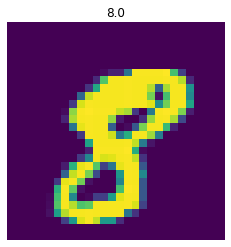

In [5]:
# prepare dataset
# load data
train = pd.read_csv('datasets/digit-recognizer/train.csv', dtype=np.float32)

# split data info features(pixels) and labels
targets_numpy = train.label.values
features_numpy = train.loc[:, train.columns != "label"].values / 255 # normalization

# train test split
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, targets_numpy, test_size=0.2, random_state=42)

# create feature and targets tensor for train set
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# pytorch train and test sets
train = TensorDataset(featuresTrain, targetsTrain)
test = TensorDataset(featuresTest, targetsTest)

# data loader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

# visualize one of the images in dataset
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.show()

In [9]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 8000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = TensorDataset(featuresTrain,targetsTrain)
test = TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create RNN
input_dim = 28    # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 10   # output dimension

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward propagation
        outputs = model(train)
        
        # calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # calculating gradients
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            # calculate accuracy
            correct = 0
            total = 0
            # iterate through test dataset
            for images,labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # forward propagation
                outputs = model(images)
                
                # get predictions from the max value
                predicted = torch.max(outputs.data, 1)[1]
                
                # total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if  count % 500 == 0:
                # print loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.627303957939148  Accuracy: 56.238094329833984 %
Iteration: 1000  Loss: 0.8639002442359924  Accuracy: 69.10713958740234 %
Iteration: 1500  Loss: 0.4026123881340027  Accuracy: 85.5 %
Iteration: 2000  Loss: 0.3420375883579254  Accuracy: 88.95237731933594 %
Iteration: 2500  Loss: 0.24067728221416473  Accuracy: 91.03571319580078 %
Iteration: 3000  Loss: 0.17339842021465302  Accuracy: 92.02381134033203 %
Iteration: 3500  Loss: 0.3758043050765991  Accuracy: 91.69047546386719 %
Iteration: 4000  Loss: 0.1905880570411682  Accuracy: 92.52381134033203 %
Iteration: 4500  Loss: 0.34787413477897644  Accuracy: 93.77381134033203 %
Iteration: 5000  Loss: 0.1870606243610382  Accuracy: 94.28571319580078 %
Iteration: 5500  Loss: 0.2219662070274353  Accuracy: 94.8452377319336 %
Iteration: 6000  Loss: 0.1945006549358368  Accuracy: 94.82142639160156 %
Iteration: 6500  Loss: 0.09972929209470749  Accuracy: 93.91666412353516 %
Iteration: 7000  Loss: 0.19988372921943665  Accuracy: 95.55952

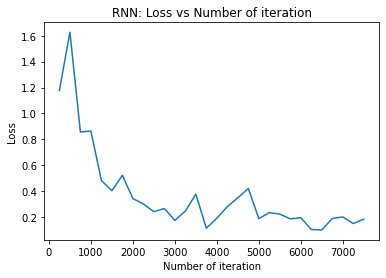

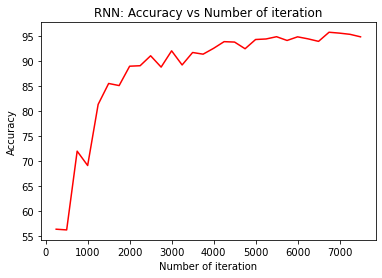

In [13]:
# visualization loss
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy
plt.plot(iteration_list, accuracy_list, color="red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.show()